In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim

from torchts.nn.loss import quantile_loss
from torchts.nn.model import TimeSeriesModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility

In [24]:
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

# Generate data

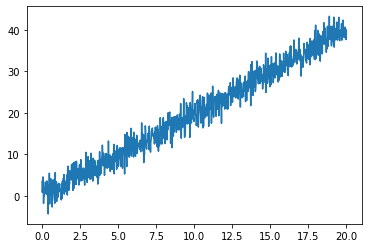

In [25]:
# generate linear time series data with some noise
n = 1000
x_max = 20
slope = 2
scale = 2

x = torch.from_numpy(np.linspace(0, x_max, n).reshape(-1, 1).astype(np.float32))
y = slope * x + np.random.normal(0, scale, n).reshape(-1, 1).astype(np.float32)

plt.plot(x, y)
plt.show()

### Split data set

In [26]:
x_train, x_test,y_train,y_test = train_test_split(x,y,test_size =0.2)

In [27]:
# easier for future ploting 
x_train_sort = x_train.sort(dim = 0)[0]
y_train_sort = y_train[x_train.sort(dim = 0)[1].flatten()]
x_test_sort = x_test.sort(dim = 0)[0]
y_test_sort = y_test[x_test.sort(dim = 0)[1].flatten()]

# Define model that predicts quantiles

In [28]:
class QuantileLSTM(TimeSeriesModel):
    def __init__(
        self, input_size, output_size, hidden_size, optimizer, quantile=0.5, mode=None,method=None,significance=None, **kwargs
    ):
        super().__init__(
            optimizer,
            criterion=quantile_loss,
            criterion_args={"quantile": quantile},
            method=method,
            mode=mode,
            significance=significance,
            **kwargs
        )
        n_quantiles = 1 if isinstance(quantile, float) else len(quantile)
        self.lstm = nn.ModuleList(
            [nn.LSTMCell(input_size, hidden_size) for _ in range(output_size)]
        )
        self.linear = nn.ModuleList(
            [nn.Linear(hidden_size, n_quantiles) for _ in range(output_size)]
        )

    def forward(self, x, y=None, batches_seen=None):
        hidden, _ = zip(*[m(x) for m in self.lstm])
        out = [m(h) for m, h in zip(self.linear, hidden)]
        return torch.hstack(out)

# Train model to predict multiple quantiles

In [29]:
input_size = 1
output_size = 1
hidden_size = 16
optimizer = optim.Adam
optimizer_args = {"lr": 0.05}
max_epochs =30
batch_size = 10
quantile = [0.025, 0.5, 0.975]

model = QuantileLSTM(
    input_size,
    output_size,
    hidden_size,
    optimizer,
    quantile=quantile,
    method='conformal',
    mode='regression',
    significance=0.1,
    optimizer_args=optimizer_args,
    scaler = None
    # scaler= StandardScaler()
)

In [30]:
model.fit(x_train, y_train, max_epochs=max_epochs, batch_size=batch_size)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name   | Type       | Params
--------------------------------------
0 | lstm   | ModuleList | 1.2 K 
1 | linear | ModuleList | 51    
--------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/judyyy/opt/anaconda3/envs/spatiotemporal/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of c

Epoch 0:  60%|▌| 48/80 [00:00<00:00, 175.59it/s, loss=11.9, v_num=167, train_los
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|█| 80/80 [00:00<00:00, 226.04it/s, loss=11.9, v_num=167, train_los
Epoch 1:  60%|▌| 48/80 [00:00<00:00, 178.40it/s, loss=2.63, v_num=167, train_los
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|█| 80/80 [00:00<00:00, 236.59it/s, loss=2.63, v_num=167, train_los
Epoch 2:  60%|▌| 48/80 [00:00<00:00, 193.33it/s, loss=1.88, v_num=167, train_los
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|█| 80/80 [00:00<00:00, 254.19it/s, loss=1.88, v_num=167, train_los
Epoch 3:  60%|▌| 48/80 [00:00<00:00, 170.43it/s, loss=1.28, v_num=167, train_los
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|█| 80/80 [00:00<00:00, 229.33it/s, loss=1.28, v_num=167, train_los
Epoch 4:  60%|▌| 48/80 [00:00<00:00, 190.43it/s, loss=1.44, v_num=167, train_los
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|█| 80/80 [00:00<00:00, 247.00it/s, loss=1.44, v_num=167, train_los
Epoch 5:  60%|▌| 48/80 [00:00<00:00

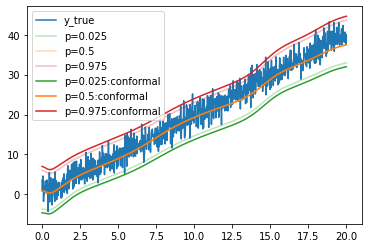

In [31]:
y_pred = model.predict(x)
y_pred_conformal = model.conformal_predict(x)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x, y, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x, y_pred[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x, y_pred_conformal[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")
plt.legend()
plt.show()

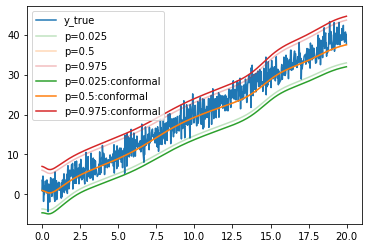

In [32]:
# plot x_train
y_pred = model.predict(x_train_sort)
y_pred_conformal = model.conformal_predict(x_train_sort)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_train_sort, y_train_sort, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_train_sort, y_pred[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_train_sort, y_pred_conformal[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")
plt.legend()
plt.show()

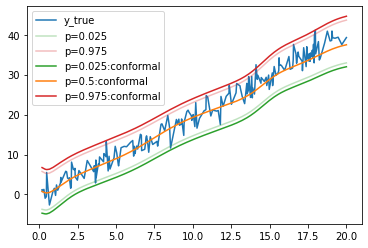

In [33]:
# plot x_test
y_pred = model.predict(x_test_sort)
y_pred_conformal = model.conformal_predict(x_test_sort)
n_quantiles = len(quantile)
cycle_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_index = [2, 1, 3]

plt.plot(x_test_sort, y_test_sort, label="y_true")

for i, c in zip(range(n_quantiles), color_index):
    if i != 1:
        plt.plot(x_test_sort, y_pred[:, i], c=cycle_colors[c], label=f"p={quantile[i]}",alpha = 0.3)

for i, c in zip(range(n_quantiles), color_index):
    plt.plot(x_test_sort, y_pred_conformal[:, i], c=cycle_colors[c], label=f"p={quantile[i]}:conformal")
plt.legend()
plt.show()